# Анализ оттока клиентов

В предстоящем исследовании нам предстоит выделить сегменты клиентов регионального банка «Метанпром», которые склонны уходить из банка. Банк имеет филиалы в трёх городах: Ярославль, Ростов Великий и Рыбинск. Нам доступны данные о клиентах из csv-файла по ссылке.
Заказчиком исследования выступает отдел маркетинга. 
В результате исследования мы хотим максимально эффективно выделить сегменты отточных клиентов, чтобы они были однородными, высокоточными и покрывали максимум проблемных зон банка. А также проверить гипотезы:

- о различии дохода между клиентами, которые ушли и теми, которые остались


Будем готовы к появлению новых (как минимум ещё одной!) гипотез, которые, возможно, также будут интересны нам как исследователям.

# 1. Обзор данных

- Предварительное знакомство с данными
- Проверка типов данных в столбцах

In [1]:
import pandas as pd

import warnings 
warnings.simplefilter("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import stats as st

In [2]:
# Считываю новую таблицу в переменную df

path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

In [3]:
# Посмотрим первые 10 строк таблицы
display(df.head(10))

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0


In [4]:
# Ознакомимся с информацией о таблице 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


Приведём названия столбцов к нижнему регистру, имя столбца userid дополним символом нижнего подчёркивания «_», а ещё добавим нашей таблице пару столбцов, которые будут содержать результаты перевода категориальных переменных в количественные: значения пола и значения города, в котором находится филиал банка.

In [5]:
df.columns = df.columns.str.lower()
# почему-то с помощью метода rename() изменить имя столбца 'userid' на 'user_id' нельзя
df = df.rename(columns={'userid':'user_id'})


In [6]:
# Прежде, чем переводить значения в числовые, изучим, какие вообще есть значения в столбце 'gender'
df['gender'].value_counts()

М    5008
Ж    4992
Name: gender, dtype: int64

In [7]:
# И изучим, какие значения есть в столбце 'city'
df['city'].value_counts()

Ярославль    5906
Рыбинск      2663
Ростов       1431
Name: city, dtype: int64

In [8]:
# Создадим два новых столбца

df['gender_int'] = df['gender'].map({'М':1, 'Ж':0})

df['city_yar'] = df['city'].eq('Ярославль')
df['city_ryb'] = df['city'].eq('Рыбинск')
df['city_ros'] = df['city'].eq('Ростов')

for i in ['city_yar', 'city_ryb', 'city_ros']:
    df[i] = df[i].astype(int)

In [9]:
# Убедимся, что все сделанные операции прошли корректно 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
 12  gender_int     10000 non-null  int64  
 13  city_yar       10000 non-null  int64  
 14  city_ryb       10000 non-null  int64  
 15  city_ros       10000 non-null  int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 1.2+ MB


In [10]:
# приведём тип данных в столбце 'score' к целочисленному типу, чтобы избавиться от десятичных частей: они всегда равны нулю
df['score'] = df['score'].astype(int)


# 2. Предобработка данных

- Обратим внимание на пропуски в данных и выясним, к какому типу относятся данные пропуски. Изучим, как строки с пропусками зависят от имеющихся данных и обоснуем, исходя из этого, что с ними стоит сделать.

In [11]:
# Проверим данные таблицы на наличие грубых дубликатов
df.duplicated().sum()

1

In [12]:
# Избавимся от грубого дубликата
df = df.drop_duplicates().reset_index(drop=True)

# Убедимся, что наша таблица более не содержит грубых дубликатов
df.duplicated().sum()

0

In [13]:
# Проверим, есть ли дубликаты в столбце с идентификаторами клиентов
df['user_id'].duplicated().sum()

72

Мы обнаружили 72 дубликата в столбце с идентификаторами клиентов. Изучим их

In [14]:
duplicated_ids = df[df['user_id'].duplicated()]['user_id']

df.query('user_id in @duplicated_ids').sort_values('user_id').head(50)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_int,city_yar,city_ryb,city_ros
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0,1,0,0
1893,116540,883,Ярославль,Ж,55,1,362756.49,3,0,1,175920.48,1,0,1,0,0
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,0,1,0
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0,1,0,0
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,0,1,0
5896,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,1,1,0,0
8638,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,1,0,1,0
1411,123461,829,Рыбинск,Ж,59,0,96222.44,2,0,1,102771.55,1,0,0,1,0
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0,1,0,0
9774,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0,0,1,0


Мы видим, что записи, которые соответствуют задублированным id существенно отличаются. Например, в случае с id 127440 — клиенту в одной из записей 60 лет, а в другой записи — 26. Это явно не один и тот же клиент и работать ни с одной, ни с другой записью, приняв какую-то за верную мы не сможем. Просто не существует разумного способа выбрать один из двух вариантов. Причиной таких дублей, омог стать человеческий фактор: специалисты банка при заполнении данных пользователей могли ошибиться в цифрах, внося записи вручную. 

In [15]:
part = len(df.query("user_id in @duplicated_ids")) / len(df)
print('Доля строк с задублированными id составляет {:.2%}'.format(part))

Доля строк с задублированными id составляет 1.44%


Так как доля таких строк чуть более процента, то ради "чистых" данных, мы избавимся от всех этих строк. 

In [16]:
df = df.query("user_id not in @duplicated_ids")

# Убедимся, что таблица df более не содержит дублирующих id
len(df.query("user_id in @duplicated_ids"))

0

Теперь обратим внимание на пропуски в столбце 'balance' и изучим распределение значений этого столбца. 

In [17]:
df['balance'].isna().sum() # посчитаем количество пропусков в этом столбце

2247

In [18]:
part = df['balance'].isna().sum() / len(df)
print('Доля строк с пропусками в столбце "balance" составляет {:.1%}'.format(part))

Доля строк с пропусками в столбце "balance" составляет 22.8%


22.8% — это уже серьёзная, похожая на систематическую, ошибка. Здесь мы, очевидно, имеем дело с техническим сбоем. Рассмотрим строки с пропусками подробнее

In [19]:
df.query('balance.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_int,city_yar,city_ryb,city_ros
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,0,1,0
9,133130,906,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0,0,1,0,0
10,148929,927,Ростов,М,52,0,NaN,1,1,1,196820.07,0,1,0,0,1
11,172184,921,Ростов,М,41,0,NaN,1,1,1,217469.48,0,1,0,0,1
19,127034,922,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,208085,876,Ростов,М,38,0,NaN,1,0,0,171763.69,0,1,0,0,1
9983,125941,729,Ярославль,Ж,42,0,NaN,1,1,1,687538.70,0,0,1,0,0
9992,219924,884,Рыбинск,Ж,36,0,NaN,1,1,1,169844.88,0,0,0,1,0
9995,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,1,1,0,0


Оценим пропуски в данных столбца 'balance' по филиалам

In [20]:
df.query('balance.isna()').groupby('city')['city'].count()

city
Ростов        235
Рыбинск       568
Ярославль    1444
Name: city, dtype: int64

Пропуски существуют во всех трёх городах, больше всего их в Ярославле, меньше всего — в Ростове. Прежде, чем мы оценим пропуски в разрезе признака оттока, изучим соотношения доли клиентов с пропусками в каждом филиале.

In [21]:
rostov_part = 235 / len(df.query('city == "Ростов"'))
rybinsk_part = 568 / len(df.query('city == "Рыбинск"'))
yaroslavl_part = 1444 / len(df.query('city == "Ярославль"'))

In [22]:
city_label_dict = {
    rostov_part : 'Ростов',
    rybinsk_part : 'Рыбинск',
    yaroslavl_part : 'Ярославль'
}

for i, j in city_label_dict.items():
    print('Процент клиентов с пропусками в признаке баланса в городе ' + j + ' составляет {:.2%}'.format(i))

Процент клиентов с пропусками в признаке баланса в городе Ростов составляет 16.58%
Процент клиентов с пропусками в признаке баланса в городе Рыбинск составляет 21.66%
Процент клиентов с пропусками в признаке баланса в городе Ярославль составляет 24.83%


В процентном соотношении больше всего пропусков в признаке баланса у клиентов города Ярославль — это 24.83%. Далее идёт город Рыбинск со значением 21.66% и меньше всего пропусков мы видим в городе Ростов. Если обратиться к Википедии и посмотреть население этих городов, то порядок убывания численности населения будет тем же: больше всего население в городе Ярославль: около 600 тысяч человек. В Рыбинске проживает 177 тысяч человек, а в Ростове Великом — чуть менее 30 тысяч. Видим связь: чем больше население города (и чем, соответственно, больше клиентов в филиале), тем больше доля пропусков в признаке баланса. Как будто кто-то или что-то устаёт от количества работы и начинает совершать ошибки по мере увеличения её объёмов. А вот теперь  оценим пропуски в разрезе признака оттока, изучим соотношения доли клиентов с пропусками в каждом филиале.

In [23]:
df.query('balance.isna()').groupby('churn')['churn'].count()

churn
0    2234
1      13
Name: churn, dtype: int64

In [24]:
# средний остаток по признаку оттока
df.groupby('churn').agg({'balance' : ['count', 'mean']})

balance              
        count          mean
churn                      
0        5851  7.326237e+05
1        1757  1.127694e+06

В строках с пропусками значений есть как отточные клиенты, так и те, кто остался в банке. Однако, клиенты с пропусками в балансе практически не уходят — таких записей всего 13. Можно говорить о том, что наличие пропуска в балансе является признаком отсутствия оттока.

In [25]:
# проверим, сколько записей с нулевым остатком содержит столбец 'balance'
df.query('balance == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_int,city_yar,city_ryb,city_ros
3900,179831,730,Ярославль,М,18,0,0.0,2,1,1,64548.33,0,1,1,0,0
6757,148456,813,Ярославль,М,20,2,0.0,2,1,0,23876.51,0,1,1,0,0


Таких записей всего две, что представляет собой совсем незначительную часть данных. Пропуски — это точно не нулевые значения.

Итак, пропуски в столбце 'balance' не связаны с признаком оттока клиента: они есть и у тех, кто перестал являться клиентом банка (правда, всего у 13 человек), также они есть и у тех, кто клиентом остаётся. У клиентов с признаком оттока существуют остатки на счетах. Практически у всех клиентов банка существуют остатки на счетах за исключением двух клиентов, которые по-прежнему являются клиентами. Пропуски данных есть во всех трёх городах, где находятся филиалы банка.

Количество пропусков в записях для клиентов из Ярославля можно объяснить тем, что Ярославль является областным центром, то есть более крупным городом, то есть в нём живёт больше людей и спрос на банковские продукты, соответствено, выше. Но мы можем говорить о существовании какой-то ошибки, которая систематическая, то есть где-то при выгрузке она возникает и характерна для каждого из существующих филиалов. Согласно классификации пропусков, мы имеем здесь тип MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

# 3. EDA — Исследовательский анализ данных

- сравним портреты отточных и неотточных клиентов, построим распределения признаков у первой и второй групп.
- исследуем коррелирующие признаки, построив матрицу корреляций

In [26]:
# Изучим средние значения показателей
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_int,city_yar,city_ryb,city_ros
count,9855.000000,9855.000000,9855.000000,9855.000000,7.608000e+03,9855.000000,9855.000000,9855.000000,9.855000e+03,9855.000000,9855.000000,9855.000000,9855.000000,9855.000000
mean,171659.303805,848.510604,42.865956,2.629934,8.238616e+05,1.871740,0.680365,0.521563,1.475957e+05,0.179604,0.500254,0.590157,0.266058,0.143785
std,33684.008857,65.394268,12.140883,1.977634,1.982674e+06,0.795632,0.466359,0.499560,1.390058e+05,0.383877,0.500025,0.491829,0.441917,0.350889
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,142585.500000,802.000000,34.000000,0.000000,2.945396e+05,1.000000,0.000000,0.000000,7.508276e+04,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172466.000000,852.000000,40.000000,3.000000,5.226297e+05,2.000000,1.000000,1.000000,1.194601e+05,0.000000,1.000000,1.000000,0.000000,0.000000
75%,200976.000000,899.000000,51.000000,4.000000,9.754941e+05,2.000000,1.000000,1.000000,1.744957e+05,0.000000,1.000000,1.000000,1.000000,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000


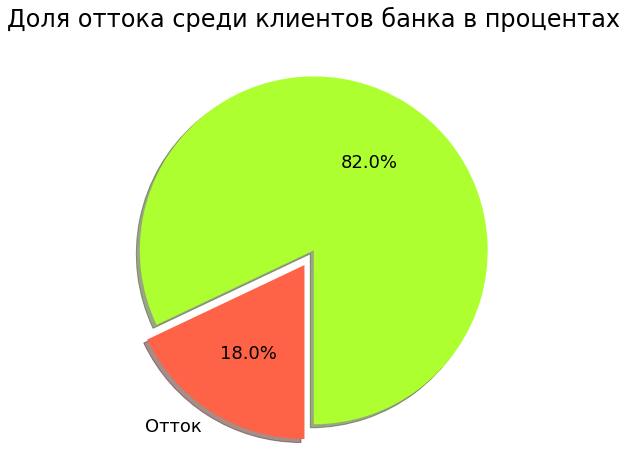

In [27]:

sizes = df['churn'].value_counts(sort = True)
colors = ["GreenYellow","Tomato"] 
labels = '', 'Отток'
explode = (0, 0.1)
rcParams['figure.figsize'] = 8, 8

# Plot
plt.pie(sizes, explode=explode, colors=colors, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=270, textprops={'fontsize': 18})

plt.title('Доля оттока среди клиентов банка в процентах', fontdict = {'fontsize' : 24})
plt.show()

Банк потерял около 18% клиентов. Рассмотрим признаки подробнее.

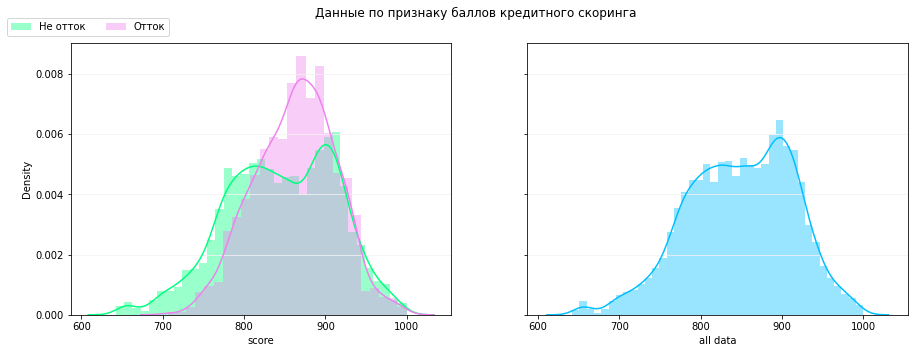

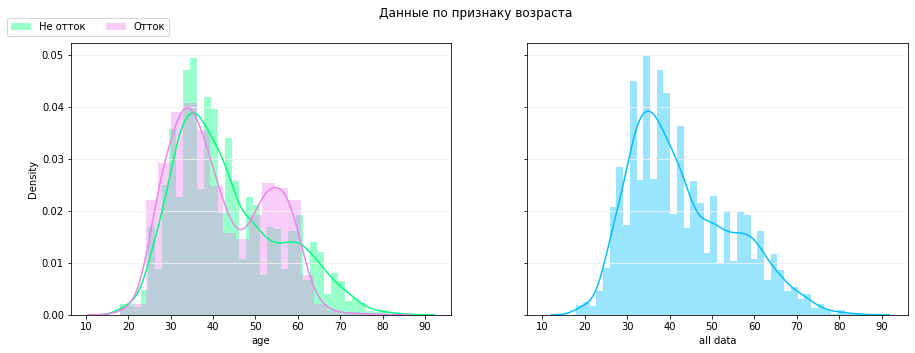

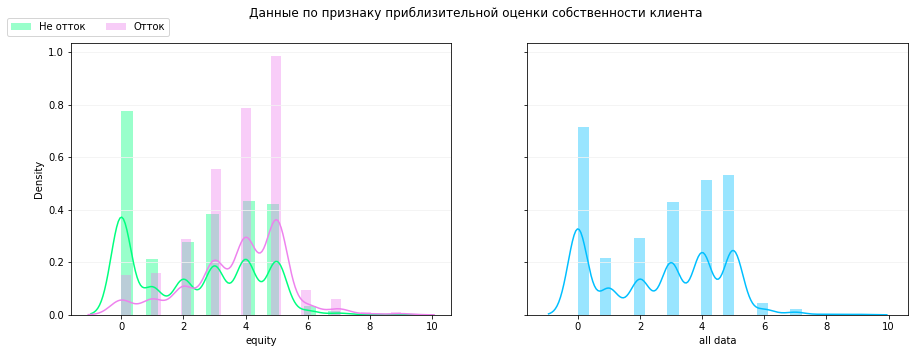

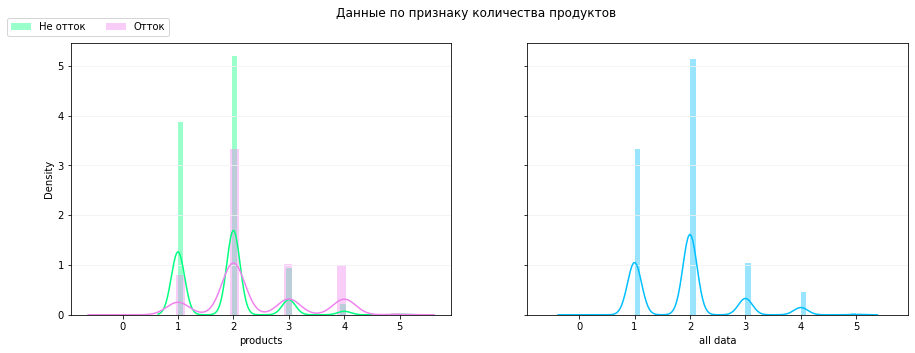

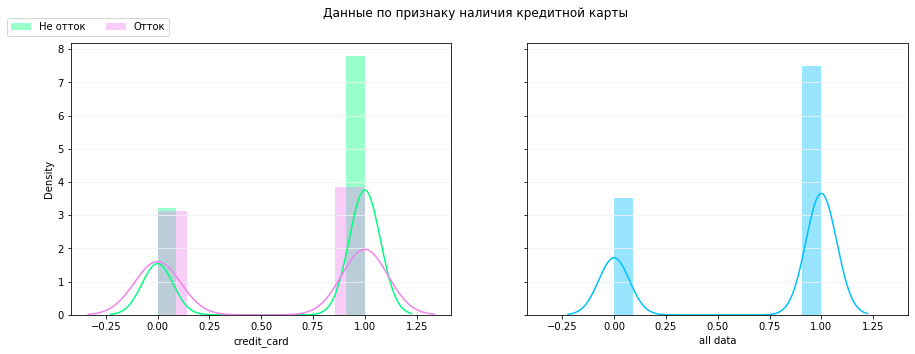

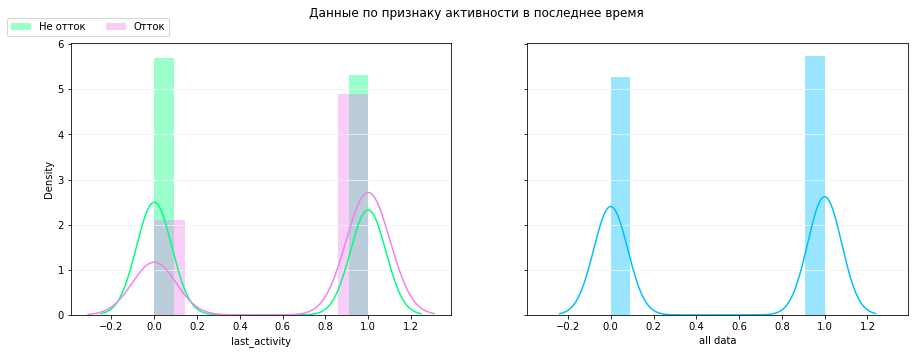

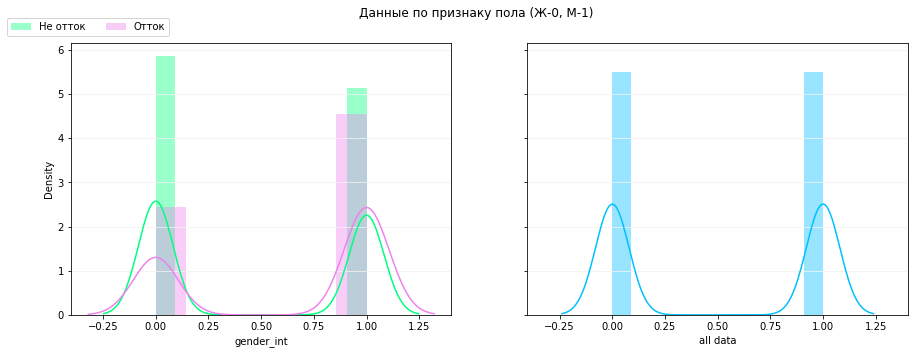

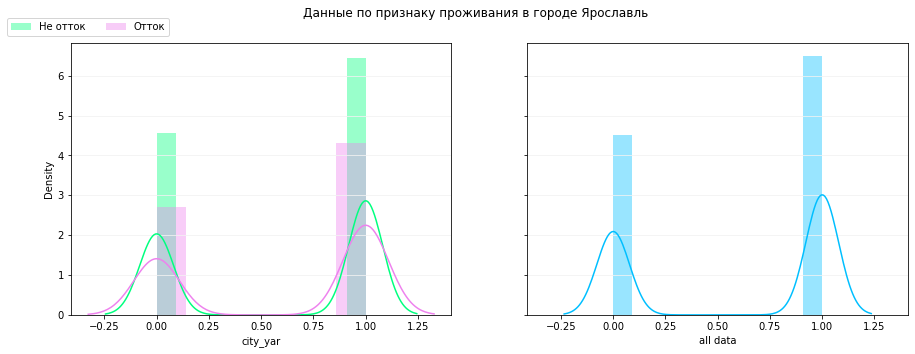

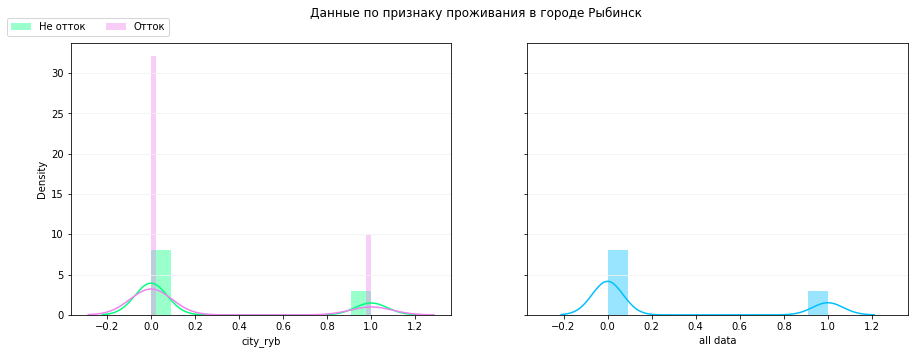

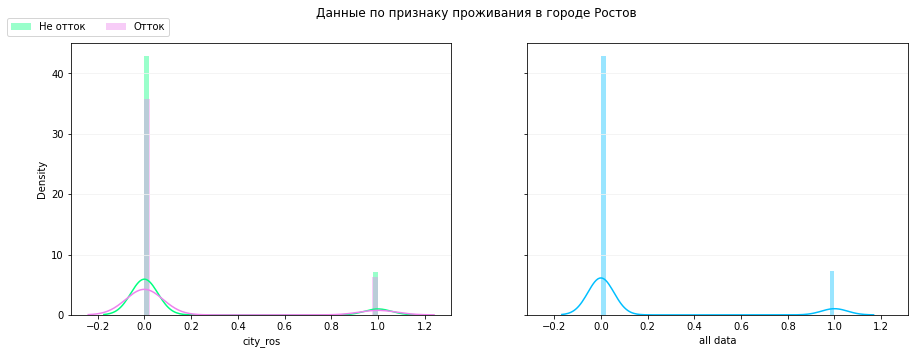

In [28]:
# создадим список columns, который будет содержать имена столбцов таблицы df2 кроме имён, указанных внутри скобок метода drop().
columns = df.drop(['churn', 'user_id', 'city', 'gender', 'balance', 'est_salary'], axis=1).columns

# а ещё создадим словарь, чтобы подписи получились красивыми
label_dict = {
    'score': 'баллов кредитного скоринга',
    'age': 'возраста',
    'equity': 'приблизительной оценки собственности клиента',
    'balance': 'баланса',
    'products': 'количества продуктов',
    'credit_card': 'наличия кредитной карты',
    'last_activity': 'активности в последнее время',
    'est_salary': 'заработной платы клиента',
    'city_yar': 'проживания в городе Ярославль',
    'city_ryb': 'проживания в городе Рыбинск',
    'city_ros': 'проживания в городе Ростов',
    'gender_int': 'пола (Ж-0, М-1)'
}


for col in columns:
    x1 = df[df['churn']==0][col]
    x2 = df[df['churn']==1][col]
    x3 = df[col]
# plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle('Данные по признаку ' + label_dict[col])
    sns.distplot(x1 , color="SpringGreen", ax=axes[0], label='Не отток')
    sns.distplot(x2 , color="Violet", ax=axes[0], label = 'Отток')
    sns.distplot(x3 , color="DeepSkyBlue", ax=axes[1], axlabel='all data')
    fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
    axes[0].set(ylabel='Density')
    axes[0].grid(axis='y', color='0.95')
    axes[1].grid(axis='y', color='0.95')
    plt.show()

По графикам можно заметить, что к оттоку более склонны мужчины, женщины же напротив — более лояльны. Чаще всего в оттоке оказываются клиенты, которе имеют от 800 до 900 баллов кредитного скоринга, а также возрастная категория клиентов от 50 до 60 лет. Если клиент владеет кредитной картой, то он окажется в оттоке с меньшей вероятностью, чем если бы у него кредитной карты не было. Также мы можем наблюдать, что чуть более склонны к оттоку те клиенты, которые проявляли активность в последнее время. Перейдём к построению матрицы корреляций.

Построим графики по балансу и зарплате отдельно. Создадим дополнительную таблицу для построения графиков, а для того, чтобы эти графики были отображены информативно, избавимся от выбросов в данных столбцов 'balance' и 'est_salary'.

In [29]:
# Для начала изучим данные в столбцах

# Создадим "клон" таблицы df (назовём его df2), который будем использовать только для построения графиков
df2 = df[['churn', 'balance', 'est_salary']]

# Переведём значения столбца 'balance' в миллионы, чтобы избавиться от экспонентного вида числа
df2['balance'] = df2['balance'] / 1000000

df2['balance'].describe()

count    7608.000000
mean        0.823862
std         1.982674
min         0.000000
25%         0.294540
50%         0.522630
75%         0.975494
max       119.113552
Name: balance, dtype: float64

В столбце 'balance' медиана равна значению 0.52, а стандартное отклонение составляет 1.98. Границей, по которой будем избавляться от выбросов для построения графика, примем значение двух стандартных отклонений, отложенных от медианы, разумеется, в сторону увеличения. Нижней границей оставим минимальное значение 0.

In [30]:
# задаём значение границы
border_value = 0.522630 + 1.982674 * 2

balance_df = df2.query('balance < @border_value')

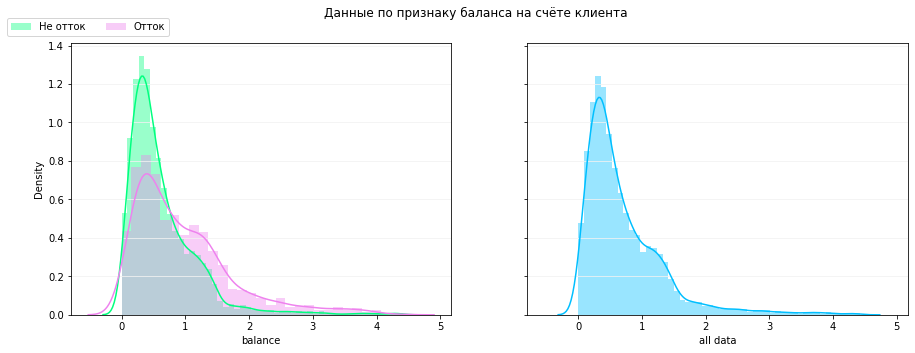

In [31]:
x1 = balance_df[balance_df['churn']==0]['balance']
x2 = balance_df[balance_df['churn']==1]['balance']
x3 = balance_df['balance']

# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Данные по признаку баланса на счёте клиента')
sns.distplot(x1 , color="SpringGreen", ax=axes[0], label='Не отток')
sns.distplot(x2 , color="Violet", ax=axes[0], label = 'Отток')
sns.distplot(x3 , color="DeepSkyBlue", ax=axes[1], axlabel='all data')
fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
axes[0].set(ylabel='Density')
axes[0].grid(axis='y', color='0.95')
axes[1].grid(axis='y', color='0.95')
plt.show()

Точно так же построим график для признака зарплаты. 

In [32]:
# Переведём значения столбца 'est_salary' в сотни тысяч, чтобы избавиться от экспонентного вида числа

df2['est_salary'] = df2['est_salary'] / 100000

df2['est_salary'].describe()

count    9855.000000
mean        1.475957
std         1.390058
min         0.025463
25%         0.750828
50%         1.194601
75%         1.744957
max        13.950644
Name: est_salary, dtype: float64

В столбце 'est_salary' медиана равна значению 1.19, что соответствует 119 тысячам, а стандартное отклонение составляет 1.39 (139 тысяч). Границей, по которой будем избавляться от выбросов для построения графика, примем значение двух стандартных отклонений, отложенных от медианы в сторону увеличения. Нижней границей оставим минимальное значение.

In [33]:
# задаём значение границы
border_value = 1.194601 + 1.390058 * 2

salary_df = df2.query('est_salary < @border_value')

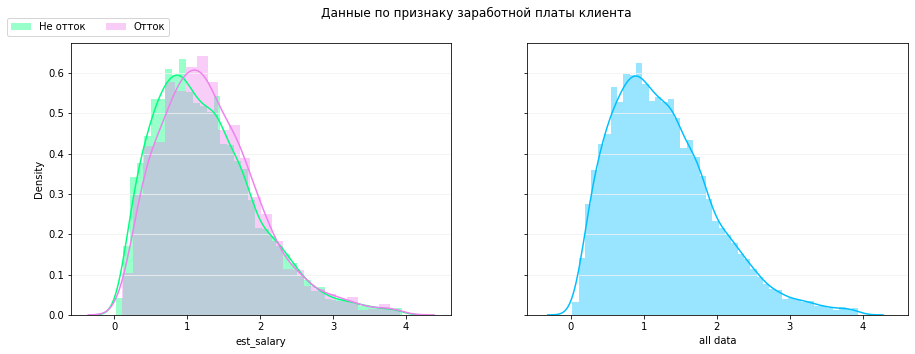

In [34]:
x1 = salary_df[salary_df['churn']==0]['est_salary']
x2 = salary_df[salary_df['churn']==1]['est_salary']
x3 = salary_df['est_salary']

# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Данные по признаку заработной платы клиента')
sns.distplot(x1 , color="SpringGreen", ax=axes[0], label='Не отток')
sns.distplot(x2 , color="Violet", ax=axes[0], label = 'Отток')
sns.distplot(x3 , color="DeepSkyBlue", ax=axes[1], axlabel='all data')
fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
axes[0].set(ylabel='Density')
axes[0].grid(axis='y', color='0.95')
axes[1].grid(axis='y', color='0.95')
plt.show()

На основании графика по балансу на счёте, мы можем судить, что к оттоку более склонны клиенты с балансом более 1-го миллиона рублей, тогда как клиенты с меньшим балансом значимо чаще остаются клиентами банка. По признаку заработной платы можно говорить о том, что клиенты с зарплатой более 100 тысяч — более склонны к оттоку. Можно сделать вывод, что более обеспеченные клиенты не нуждаются в банковских продуктах, тогда как менее обеспеченные клиенты остаются с банком, то есть проявляют лояльность.

Уделим особое внимание значениям признаков, которые являются границами отточных интервалов:
- показатель зарплаты клиента — 100 тысяч — это нижняя граница зарплаты, с которой клиенты чаще уходят в отток;
- показатель баланса клиента — 1 миллион — это также нижняя граница средств на счёте, с которой клиент принимает решение уйти из банка;
- отсутствие кредитной карты — если клиент не имеет кредитную карту, он более склонен к оттоку;
- в продолжении темы кредитной карты, которая является продуктом банка: если клиент имеет 3 и более продуктов банка, он также может уйти. То есть важно следить за тем, чтобы у клиента не было "слишком много" банковских продуктов. 
- клиенты мужского пола чаще склонны к оттоку
- клиенты в возрасте от 20 до 30 лет, а также от 50 до 60 — чаще склонны к оттоку. Возможно стоит проработать специальные программы для этих категорий клиентов
- к оттоку склонны клиенты, у которых приблизительная оценка собственности выше трёх баллов

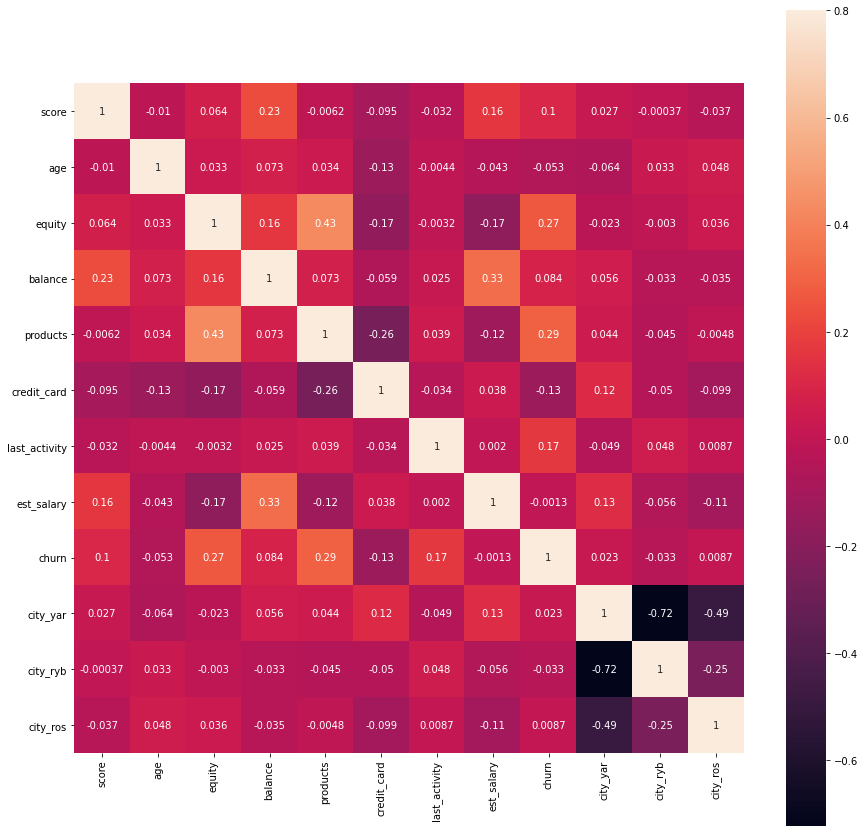

In [35]:
corr_m = df.drop(['user_id', 'city', 'gender_int'], axis=1).corr()
corr_m
# отобразим heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square=True, vmax=0.8, annot = True)

plt.show()

Сильной корреляции между признаками не обнаружено. С целевой переменной churn больше всего коррелирует переменная equity, которая характеризует приблизительную оценку собственности клиента и переменная products, которая содержит данные о количестве продуктов у клиента.

Теперь сопоставим портреты отточных и неотточных клиентов банка. Начнём с разделения датафрейма df на два разных: в первом датафрейме no_churn_df будут неотточные клиенты, во втором датафрейме — churn_df — отточные клиенты. Выделим различия между этими двумя группами клиентов.

In [36]:
no_churn_df = df.query('churn == 0')
churn_df = df.query('churn == 1')

In [37]:
table_list = [no_churn_df, churn_df]

for i in ['score', 'age', 'equity', 'balance', 'products', 'est_salary']:
    no_churn_value = 0
    churn_value = 0
    for j in range(len(table_list)):
        target_value = 0
        # Будем брать медианные значения для признаков, которые относятся к деньгам — баланс и зарплата
        if i == 'balance' or i == 'est_salary':
            target_value = round(table_list[j][i].median(), 2)
            value_type = 'Медианное значение'
        # В остальных случаях будем брать среднее значение для сравнения
        else:
            target_value = round(table_list[j][i].mean(), 2)
            value_type = 'Среднее значение'
            
        if j == 0:
            client_type = 'неотточных клиентов'
            no_churn_value = target_value
            print(f'{value_type} {label_dict[i]} для {client_type}: {target_value}')
        else:
            client_type = 'отточных клиентов'
            churn_value = target_value
            print(f'{value_type} {label_dict[i]} для {client_type}: {target_value}')
        
    perc_diff = 0
    diff = round(abs(no_churn_value - churn_value), 2)
    # делителем будет выступать бОльшее число, а делимым — разница между большим и меньшим (сохранили её в переменной diff)
    divider = 0
    if no_churn_value > churn_value:
        divider = no_churn_value
        part = diff / divider
        print('Значение для неотточных клиентов больше на {:.2%}'.format(part))
    else:
        divider = churn_value
        part = diff / divider
        print('Значение для отточных клиентов больше на {:.2%}'.format(part))
    # Пробел для удобочитаемости
    print('')

Среднее значение баллов кредитного скоринга для неотточных клиентов: 845.34
Среднее значение баллов кредитного скоринга для отточных клиентов: 863.01
Значение для отточных клиентов больше на 2.05%

Среднее значение возраста для неотточных клиентов: 43.17
Среднее значение возраста для отточных клиентов: 41.49
Значение для неотточных клиентов больше на 3.89%

Среднее значение приблизительной оценки собственности клиента для неотточных клиентов: 2.38
Среднее значение приблизительной оценки собственности клиента для отточных клиентов: 3.76
Значение для отточных клиентов больше на 36.70%

Медианное значение баланса для неотточных клиентов: 475293.3
Медианное значение баланса для отточных клиентов: 779813.55
Значение для отточных клиентов больше на 39.05%

Среднее значение количества продуктов для неотточных клиентов: 1.76
Среднее значение количества продуктов для отточных клиентов: 2.37
Значение для отточных клиентов больше на 25.74%

Медианное значение заработной платы клиента для неотточн

Портрет отточного клиента в большинстве случаев (за исключением сравнения среднего возраста) отличается от портрета неотточного клиента бОльшими показателями признаков. Где то разница незначительна: например, значение баллов кредитного скоринга для отточных клиентов выше, чем значение баллов кредитного скоринга для неотточных клиентов всего на 2.05% — 863 балла против 845. Но есть признаки, различия по которым более существенны: например, медианное значение баланса у отточных клиентов на 39% выше, чем аналогичное значение у неотточных, также среднее значение приблизительной оценки собственности клиента у отточных пользователей отличается в плюс на 36.7%, чем у неотточных пользователей. Замыкает тройку лидеров по разнице — среднее значение количества продуктов: у отточных клиентов оно выше на 25% — средний показатель 2.37 против среднего показателя 1.76.
Разница в медианных значениях заработной платы клиентов — относительно вышеописанных разниц, напротив, незначительна и составляет всего 5,6%. В среднем, отточный клиент обладает зарплатой 125109, а неотточный — 118089.


# 4. Проверка гипотез

# 4.1 Гипотеза о различии дохода между теми клиентами, которые ушли и теми клиентами, которые остались

Сформулируем гипотезы:

- H0: Статистически значимых различий между доходами клиентов, которые ушли и клиентов, которые остались — нет.
- H1: Статистически значимые различия между доходами клиентов, которые ушли и клиетов, которые остались — есть.

In [38]:
# Здесь воспользуемся таблицей df2, которую мы привлекали к построению графиков, так как в ней данные о зарплате приведены к
# сотням тысяч и мы не столкнёмся с неудобочитаемостью экспонентных чисел.
# Кроме того, мы помним, что данные столбца 'est_salary' содержат выбросы, а для корректного использования t-теста
# эти выбросы следует удалить. Сделаем это сразу.

border_value = 1.194601 + 1.390058 * 2
est_salary1 = df2.query('churn == 0 and est_salary < @border_value')['est_salary']
est_salary2 = df2.query('churn == 1 and est_salary < @border_value')['est_salary']

Убедимся, что данные est_salary1 и est_salary2 без выбросов, чтобы можно было использовать t-тест.

In [39]:
est_salary1.describe()

count    7800.000000
mean        1.255012
std         0.706953
min         0.025463
25%         0.719522
50%         1.149166
75%         1.670282
max         3.941315
Name: est_salary, dtype: float64

In [40]:
est_salary2.describe()

count    1722.000000
mean        1.318395
std         0.683577
min         0.108803
25%         0.815450
50%         1.222162
75%         1.713632
max         3.920730
Name: est_salary, dtype: float64

Теперь для проверки гипотез на равенство предполагаемых средних двух генеральных совокупностей будем использовать t-тест. Препятствий для его использования нет: генеральные совокупности не зависят друг от друга, выборочные средние распределены нормально (выборочные средние всегда показывают распределение близкое к нормальному и центром такого распределения становится истинное среднее генеральной совокупности). А так как выборки будут иметь разные размеры, то мы укажем неравенство дисперсий с помощью параметра equal_var метода scipy.stats.ttest_ind(). Для удобства автоматизируем процесс проверки гипотез и создадим функцию, которая будет осуществлять проверку на равенство предполагаемых средних двух генеральных совокупностей и выводить на экран результат проверки.

In [41]:
def check_hypothesis(first_set, second_set):
    
    alpha = .05 # критический уровень статистической значимости
    
    # определеем значение для параметра equal_var
    
    if len(first_set) == len(second_set):
        ev = True
    else:
        ev = False
        
    results = st.ttest_ind(first_set, second_set, equal_var=ev)
    
    print('p-значение:', results.pvalue)
    
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [42]:
check_hypothesis(est_salary1, est_salary2)

p-значение: 0.0005473847026401745
Отвергаем нулевую гипотезу


Мы отвергли нулевую гипотезу. Это говорит о том, что мы можем утверждать с уверенностью как минимум на 95% (так как был задан критический уровень статистической значимости, равный 0.05), что статистически значимые различия между доходами клиентов, которые ушли и клиетов, которые остались — есть.

# 4.2 Гипотеза о различии баллов кредитного скоринга между теми клиентами, которые ушли и теми клиентами, которые остались

Сформулируем гипотезы:

- H0: Статистически значимых различий между баллами кредитного скоринга клиентов, которые ушли и клиентов, которые остались — нет.
- H1: Статистически значимые различия между баллами кредитного скоринга клиентов, которые ушли и клиетов, которые остались — есть.

In [43]:
score1 = df.query('churn == 0')['score']
score2 = df.query('churn == 1')['score']

Убедимся, что данные score1 и score2 без выбросов, чтобы можно было использовать t-тест.

In [44]:
score1.describe()

count    8085.000000
mean      845.335683
std        67.939987
min       642.000000
25%       796.000000
50%       848.000000
75%       900.000000
max      1000.000000
Name: score, dtype: float64

In [45]:
score2.describe()

count    1770.000000
mean      863.012994
std        49.710972
min       706.000000
25%       828.000000
50%       866.000000
75%       898.000000
max      1000.000000
Name: score, dtype: float64

По предыдущим графикам мы помним, что распределение баллов кредитного скоринга в случаях как с отточными клиентами, так и с теми, кто остался — нормальное и не содержит выбросов, поэтому использовать t-тест мы можем. Описание данных также говорит об отстутсвии выбросов.

In [46]:
check_hypothesis(score1, score2)

p-значение: 1.2504447271939253e-35
Отвергаем нулевую гипотезу


Гипотезу о различии баллов кредитного скоринга между теми клиентами, которые ушли и теми клиентами, которые остались, принимаем. Статистически значимые различия между баллами кредитного скоринга клиентов, которые ушли и клиентов, которые остались — есть!

# 4.3 Гипотеза о различии возраста между теми клиентами, которые ушли и теми клиентами, которые остались

Сформулируем гипотезы:

- H0: Статистически значимых различий в возрасте клиентов, которые ушли и клиентов, которые остались — нет.
- H1: Статистически значимые различия в возрасте клиентов, которые ушли и клиентов, которые остались — есть.

In [47]:
age1 = df.query('churn == 0')['age']
age2 = df.query('churn == 1')['age']

In [48]:
age1.describe()

count    8085.000000
mean       43.166729
std        12.352631
min        18.000000
25%        34.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

In [49]:
age2.describe()

count    1770.000000
mean       41.492090
std        11.021855
min        18.000000
25%        33.000000
50%        39.000000
75%        52.000000
max        79.000000
Name: age, dtype: float64

Значения возраста среди тех клиентов, которые ушли и остались — распределены нормально и не имеют выбросов. Значит, мы можем применять t-тест.

In [50]:
check_hypothesis(age1, age2)

p-значение: 1.6549989007231503e-08
Отвергаем нулевую гипотезу


Гипотезу о различии возраста между теми клиентами, которые ушли и теми клиентами, которые остались тоже отвергаем. Статистически значимые различия между возрастом клиентов, которые ушли клиентов, которые остались — есть.

# 5. Разделение на сегменты

Проведём сегментацию клиентов на основе стратегических показателей.

- Как мы выяснили ранее, медианное значение баланса у отточных клиентов на целых 39% выше, чем аналогичное значение у неотточных клиентов. Также мы помним, что показатель баланса клиента — 1 миллион — это нижняя граница средств на счёте, с которой клиент намного чаще принимает решение уйти из банка.


- Высоки различия в характеристиках среднего значения приблизительной оценки собственности клиента: у отточных пользователей это значение отличается в плюс на 36.7%. К оттоку склонны клиенты, у которых приблизительная оценка собственности выше трёх баллов.


- На 25% в плюс отличается значение количества продуктов у отточных клиентов. Что касается границ интервалов, то если клиент имеет 3 и более продуктов банка, он также может уйти.

- Возраст: отточными являются категории клиентов в возрасте от 20 до 35 лет, а также в возрасте от 50 до 60 лет
- Пол: мужчины более склонны к оттоку
- Наличие кредитной карты: отток случается значимо чаще, если кредитной карты нет.

Итак, напомним пограничные значения для оттока:
- Баланс: 1 млн +
- Оценка собственности: 4+
- Количество продуктов: 3+
- Возраст: от 20 до 35 и от 50 до 60
- Пол: мужчины
- Кредитная карта: отсутствие

In [51]:
def make_segments(row):
    
    balance = row['balance']
    equity = row['equity']
    products = row['products']
    age = row['age']
    gender_int = row['gender_int']
    credit_card = row['credit_card']
    
    # Так как наибольшая корреляция замечена у целевой переменной с характеристиками products и equity
    # Сохраним это условие в переменной для сегментации, часть исследуемых сегментов будет содержать клиентов со значениями
    # этих характеристик, которые определяют отточность
    
    # отдельная переменная для условия
    products_and_equity = products >= 3 and equity >= 4
    
    if products_and_equity and age >= 20 and age <= 35:
        return 'Segment 1'
    if products_and_equity and age >= 50 and age <= 60:
        return 'Segment 2'
    if products_and_equity and gender_int == 1:
        return 'Segment 3'
    if products_and_equity and credit_card == 0:
        return 'Segment 4'
    if products_and_equity and balance > 1000000:
        return 'Segment 5'
    
    # ещё одна отдельная переменная
    balance_and_products = balance > 1000000 and products >= 3
    
    if balance_and_products and credit_card == 0:
        return 'Segment 6'
    if balance_and_products and gender_int == 1:
        return 'Segment 7'
    if balance_and_products and age >= 50 and age <= 60:
        return 'Segment 8'
    if balance_and_products and age >= 20 and age <= 35:
        return 'Segment 9'
    
    # И ещё одна переменная
    balance_and_equity = balance > 1000000 and equity >= 4
    
    if balance_and_equity and credit_card == 0:
        return 'Segment 10'
    if balance_and_equity and gender_int == 1:
        return 'Segment 11'
    if balance_and_equity and age >= 20 and age <= 35:
        return 'Segment 12'
    if balance_and_equity and age >= 50 and age <= 60:
        return 'Segment 13'
    return 'Segment 14' # Другие клиенты

    
    
    

In [52]:
df['segments'] = df.apply(make_segments, axis=1)

In [53]:
churn_segments = df.pivot_table(index='segments').sort_values(by='churn', ascending=False).drop(columns=['city_ros', 'city_ryb', 'city_yar']).reset_index()


In [54]:
churn_segments['balance'] = churn_segments['balance'] / 100000

In [55]:
churn_segments

,segments,age,balance,churn,credit_card,equity,est_salary,gender_int,last_activity,products,score,user_id
0,Segment 7,43.216216,19.438340,0.702703,1.000000,2.621622,185539.228919,1.000000,0.567568,3.567568,844.783784,182797.675676
1,Segment 8,55.300000,15.593650,0.700000,1.000000,2.400000,126029.645000,0.000000,0.600000,3.600000,843.900000,158826.500000
2,Segment 9,33.200000,12.678504,0.600000,1.000000,3.000000,100263.392000,0.000000,0.000000,3.600000,834.800000,170805.800000
3,Segment 2,54.876344,17.397863,0.591398,0.365591,4.747312,136358.396290,0.553763,0.548387,3.344086,867.569892,180856.951613
4,Segment 5,48.711538,17.218802,0.500000,1.000000,4.519231,146241.644615,0.000000,0.557692,3.519231,870.576923,169922.884615
5,Segment 3,43.058577,14.306601,0.481172,0.535565,4.803347,175039.897029,1.000000,0.543933,3.426778,859.158996,173870.422594
6,Segment 1,30.915751,9.400205,0.472527,0.512821,4.739927,122446.954615,0.611722,0.611722,3.505495,866.567766,169151.886447
7,Segment 10,45.444706,21.110376,0.454118,0.000000,4.663529,191409.505671,0.536471,0.564706,1.981176,888.200000,173558.508235
8,Segment 6,49.380282,15.476407,0.352113,0.000000,2.591549,135847.997183,0.352113,0.464789,3.211268,849.971831,165875.661972
9,Segment 11,43.132616,25.950191,0.286738,1.000000,4.630824,202061.959857,1.000000,0.465950,1.702509,879.573477,173662.663082


In [56]:
# Изучаю количество записей, которые попали в сегмент. С сегментом 14 — всё понятно, это часть клиентов, которых мы не изучаем
# От сегментов, в которые входят менее 100 человек стоит отказаться?
df['segments'].value_counts()

Segment 14    8032
Segment 10     425
Segment 11     279
Segment 1      273
Segment 3      239
Segment 2      186
Segment 4      152
Segment 6       71
Segment 13      54
Segment 5       52
Segment 12      40
Segment 7       37
Segment 8       10
Segment 9        5
Name: segments, dtype: int64

In [63]:
import itertools as it

# опишем все наши отточные интервалы
intervals = [
    ("3+ продуктов", '3<=products'),
    ("4+ баллов собственности",'4 <= equity'),
    ("молодой отточный возраст",'20 <= age <= 35'),   
    ("старший отточный возраст",'50 <= age <= 60'), 
    ("мужчины",'gender_int==1'),
    ("без кредитки",'credit_card==0'),
    ("вкладчики", 'balance > 1000000'),
]

# чтобы не было ошибок, будем оборачивать логические выражения в скобки
parentheses = lambda text: "(" + text + ")"

# построим возможные варианты пересечения этих интервалов
# параметр r отвечает за общее число интервалов в варианте, их может быть и больше
examples2 = [(" и ".join([name1,name2]), " and ".join(\
            [parentheses(query1),parentheses(query2)])) 
    for (name1, query1), (name2, query2) in it.combinations(intervals,r=2)]

examples3 = [(" и ".join([name1,name2,name3]), " and ".join(\
            [parentheses(query1),parentheses(query2),parentheses(query3)])) 
    for (name1, query1), (name2, query2), (name3, query3) in it.combinations(intervals,r=3)]

examples = examples2 + examples3

# по заданным запросам делаем табличку с размерами разных групп 
# и уровнем оттока в группе и внё её
dfs_temp = []
for text, query in examples:
    this_data = df.query(query)
    other_data_idx = df.index.difference(this_data.index)
    result = this_data\
              .agg({"churn":["count","mean"]}).T
    result.loc['churn','other_churn'] = df.loc[other_data_idx].agg({"churn":"mean"}).item()
    result.index = [text]
    result = result.rename(columns={"count":"num","mean":"churn"})
    dfs_temp.append(result)
    
# придумаем коэффициент, по которому будем ранжировать группы
# поправку на размер сегмента можно выбрать и другую:
# np.log, np.sqrt, np.cbrt или вообще обойтись без поправки
df_temp = pd.concat(dfs_temp)
df_temp['coef'] = ((df_temp.num ** .4) * (df_temp.churn - df_temp.other_churn)).round(1) * 10
df_temp.dropna().sort_values('coef',ascending=False).head(20)\
       .style.format({"churn":"{:.1%}","other_churn":"{:.1%}","num":"{:.0f}","coef":"{:.0f}"})

,num,churn,other_churn,coef
мужчины и вкладчики,958,48.3%,14.7%,52
4+ баллов собственности и мужчины,1984,37.3%,13.1%,51
3+ продуктов и вкладчики,584,54.1%,15.7%,49
3+ продуктов и мужчины и вкладчики,288,67.0%,16.5%,49
4+ баллов собственности и мужчины и вкладчики,733,49.5%,15.4%,48
3+ продуктов и мужчины,737,49.4%,15.4%,48
3+ продуктов и 4+ баллов собственности,938,44.1%,15.2%,45
4+ баллов собственности и мужчины и без кредитки,686,48.7%,15.7%,45
3+ продуктов и 4+ баллов собственности и вкладчики,436,56.0%,16.2%,45
3+ продуктов и 4+ баллов собственности и мужчины,509,53.4%,16.0%,45


# 6. Общие выводы

На основе проведённого исследования мы можем сделать следующие выводы:
<br><br>
<b>На отток больше всего влияют:</b>
<ul>
    <li><b>Значение баланса:</b>
        <ul>
            <li>Чем больше баланс на счёте клиента, тем выше вероятность оттока. </li>
            <li>Медианное значение баланса у отточных клиентов на целых 39% выше, чем аналогичное значение у неотточных клиентов.</li>
            <li>Показатель баланса клиента в 1 миллион — это нижняя граница средств на счёте, с которой клиент намного чаще принимает решение уйти из банка.</li>
        </ul>
    </li>
    <li><b>Значение приблизительной оценки собственности клиента:</b>
        <ul>
            <li>У отточных пользователей это значение отличается в плюс на 36.7% по сравнению с неотточными.</li>
            <li>К оттоку склонны клиенты, у которых приблизительная оценка собственности выше трёх баллов.</li>
        </ul>
    </li>
    <li>
        <b>Большое количество продуктов</b> также негативно сказывается на лояльности клиентов, особенно, если их 3 и больше.
    </li>
    <li>
        <b>Возраст клиента:</b> существует две возрастные категории, которые склонны к оттоку: это молодые люди в возрасте от 20 до 35, а также клиенты в возрасте от 50 до 60 лет.
    </li>
</ul>

<b>Рекомендации:</b>
- Увеличивать лояльность, привлекать клиентов к более активному использованию продуктов банка, например, кредитной карты, наличие которой способствует удержанию клиента. При этом стоит следить, чтобы клиент не был "перегружен" количеством продуктов.
- Клиенты с тремя продуктами слонны к оттоку, стоит разобраться, что это за третий продукт и улучшить его качество.
- Изучить предложения конкурентов и разработать специальные условия для клиентов, на балансе которых располагается сумма средств, превышающая миллион. Следует подумать о выгодных предложениях в виде хороших годовых процентов для обладателей крупных сумм на счету, чтобы они не переходили со своими средствами в другие банки.

Ссылка на презентацию: https://disk.yandex.ru/i/IavQxzRHcTSfig